# Discretisation methods

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tslearn.piecewise import SymbolicAggregateApproximation as SAXTSLearn

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from scipy.stats import mode
from sklearn.metrics import confusion_matrix

np.random.seed(123)

%run ../sys_configs.ipynb
%run ../plots.ipynb

## Introduction

Discretisation is commonly applied to time series as a pre-processing step for subsequent methods. These follow up methods typically slide windows over the time series, creating *words* from consecutive sequences of discretised *letters.* This transforms the problem to one akin to sentiment classification based on a corpus of text data, and the approaches described below reflect this.

Begin by reading in the dataset.

In [2]:
with open('../data/train.npy', 'rb') as f:
    x_train = np.load(f)
    y_train = np.load(f).astype(np.int64)
sz, dim = x_train.shape[1:]
    
with open('../data/val.npy', 'rb') as f:
    x_val = np.load(f)
    y_val = np.load(f).astype(np.int64)
    
with open('../data/test.npy', 'rb') as f:
    x_test = np.load(f)
    y_test = np.load(f).astype(np.int64)
    
classes = np.unique(y_train)  

N_train = len(y_train)
N_val = len(y_val)
N_test = len(y_test)

Symbolic Aggregation approXimation (SAX) was introduced in [1]. It maps each observation to bins whose edges are uniform or based on quantiles. In this problem instance, the GAR data is standardised to have zero mean and unit variance so the bin edges are defined from quantiles of the standard normal distribution. Then, the

In [3]:
# SAX transform
n_sax_symbols = 8
n_paa_segments = 50
sax = SAXTSLearn(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)

In [4]:
# Fit on the train data. Then discretise the train data, then the validation data
x_train_d = sax.fit_transform(x_train)
x_val_d = sax.transform(x_val)
x_test_d = sax.transform(x_test)

# Inverse transform the discretised train and validation data for the purposes of plotting
x_train_d_inv = sax.inverse_transform(x_train_d)
x_val_d_inv = sax.inverse_transform(x_val_d)
x_test_d_inv = sax.inverse_transform(x_test_d)

In [5]:
# Convert the train and validation data to str
x_train_d = x_train_d.astype(str)
x_val_d = x_val_d.astype(str)
x_test_d = x_test_d.astype(str)

print("The shape of each sample of train data is now {}".format(x_train_d.shape[1:]))

The shape of each sample of train data is now (50, 6)


In [6]:
# Concatenate the words along the third dimension (axis=2)
x_train_d = np.apply_along_axis(lambda x: ''.join(x), 2, x_train_d)
x_val_d = np.apply_along_axis(lambda x: ''.join(x), 2, x_val_d)
x_test_d = np.apply_along_axis(lambda x: ''.join(x), 2, x_test_d)

print("The shape of each sample of train data is now {}".format(x_train_d.shape[1:]))

The shape of each sample of train data is now (50,)


## Approach 1: Symbolic Aggregation approXimation + Bag of Patterns

### Approach

The Bag of Patterns algorithm which was introduced in [2] slides a window over the discretised time series and at each increment extracts a word of the window length. The frequency of each word in the discretised time series then gets computed, producing a dictionary of word counts. This dictionary amounts to a bag of features where the features are the *words* and the counts are the *word counts*. Traditional classifiers like nearest neighbours or logistic regression can then be built on top of the bag of features.

We considered fitting separate bag of words models to each component and combining the features from each component, but this approach was found to not be competitive with fitting a model on the concatenated version of the 6 components, so is not provided in this workbook.

### Training

In the first approach, create words with length 6 by discretising the time series and then concatenating the components of the sensor data. These words form the vocabulary for the CountVectoriser. Because we use a cardinality of 8 for each component, there are $8^{6} = 262144$ possible words.

In [7]:
# Transform the words into a document-term matrix
vectoriser = CountVectorizer()
x_train_vec = vectoriser.fit_transform([' '.join(word) for word in x_train_d])
x_val_vec = vectoriser.transform([' '.join(word) for word in x_val_d])
x_test_vec = vectoriser.transform([' '.join(word) for word in x_test_d])

In [8]:
x_train_vec = np.asarray(x_train_vec.todense())
x_val_vec = np.asarray(x_val_vec.todense())
x_test_vec = np.asarray(x_test_vec.todense())

In [9]:
# Train a k-nearest neighbors classifier
knn = KNeighborsClassifier(n_neighbors=7, metric = "cosine")
knn.fit(x_train_vec, y_train)

predictions1_val = knn.predict(x_val_vec)
predictions1_test = knn.predict(x_test_vec)

In [10]:
# Compare predictions against the targets
print("Validation Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions1_val), sum(np.equal(predictions1_val, y_val))))
print("Test Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions1_test), sum(np.equal(predictions1_test, y_test))))

Validation Data - Total predictions made: 1392. Number of correct predictions: 615
Test Data - Total predictions made: 1051. Number of correct predictions: 459


Several classifiers were tested, but KNN was found to work best. The remaining parameters were found after some degree of trial and error.

### Visualise predictions for test set

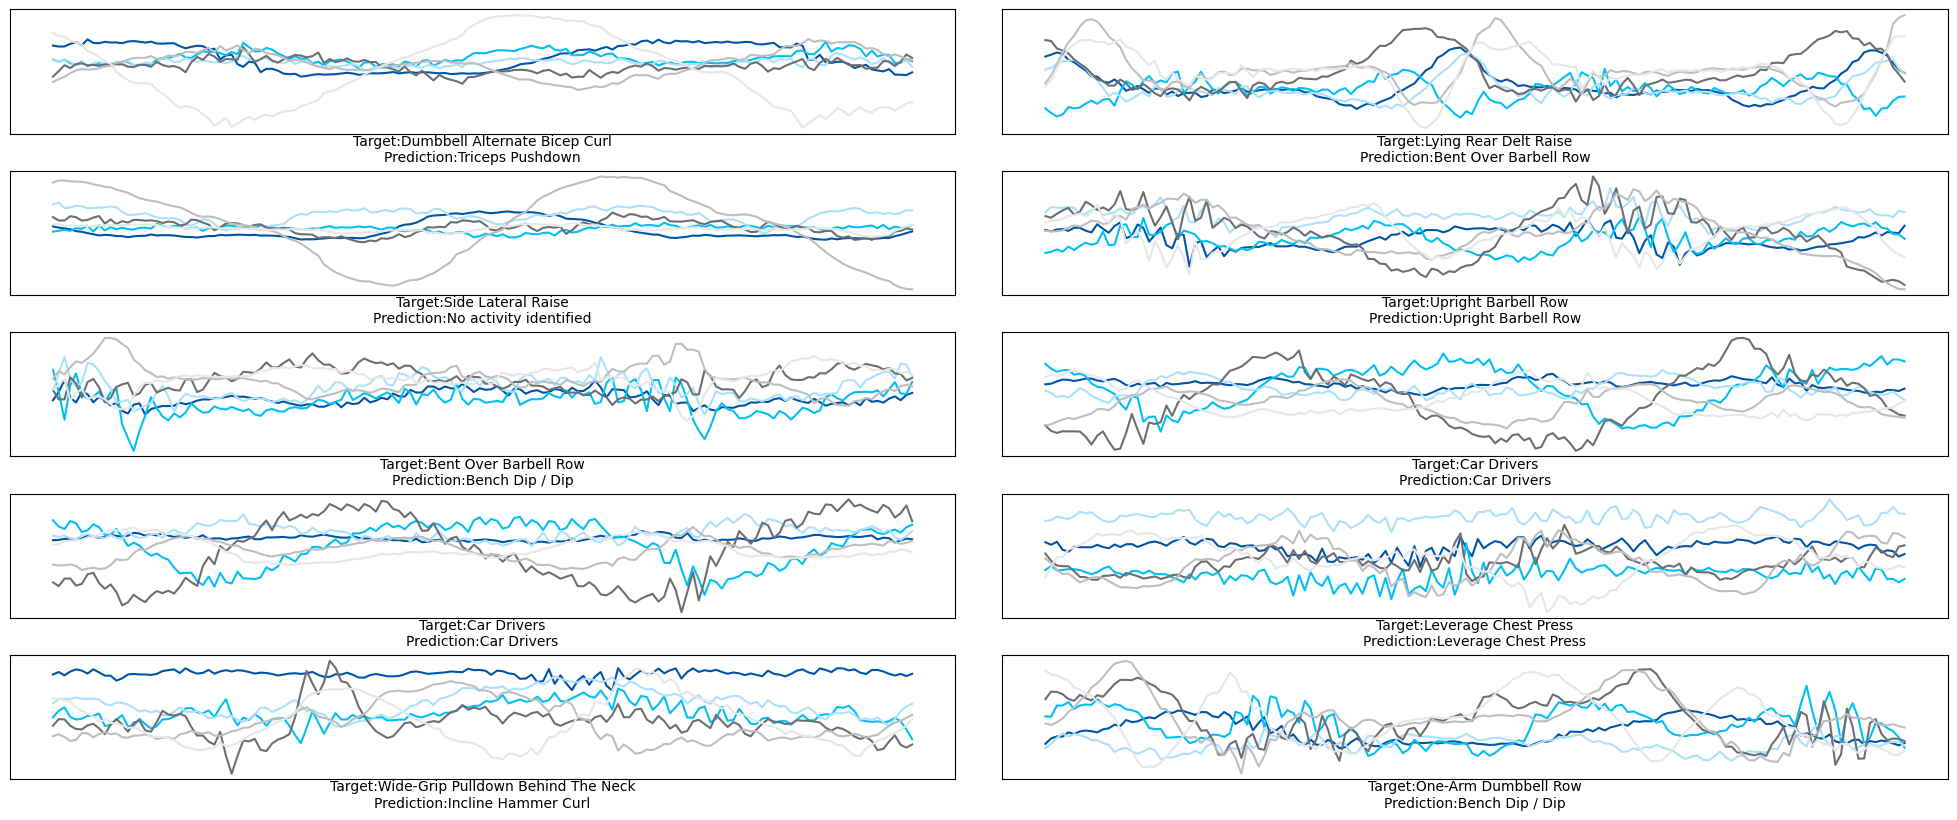

In [11]:
plot_samples(data = x_test, labels = y_test, predictions = predictions1_test)

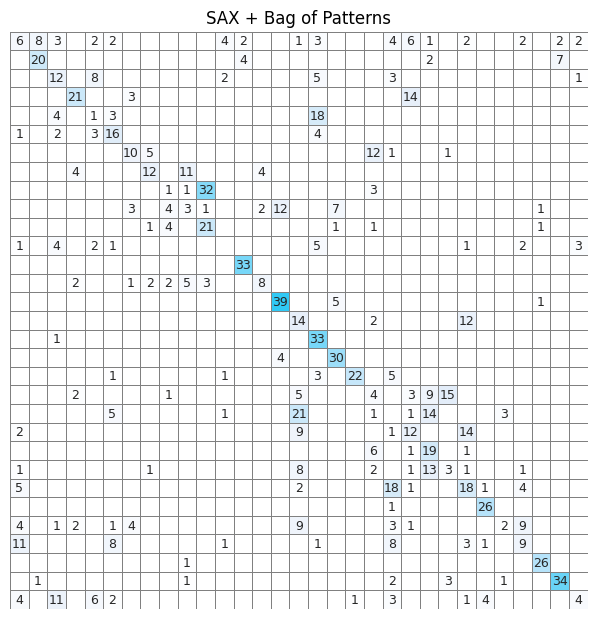

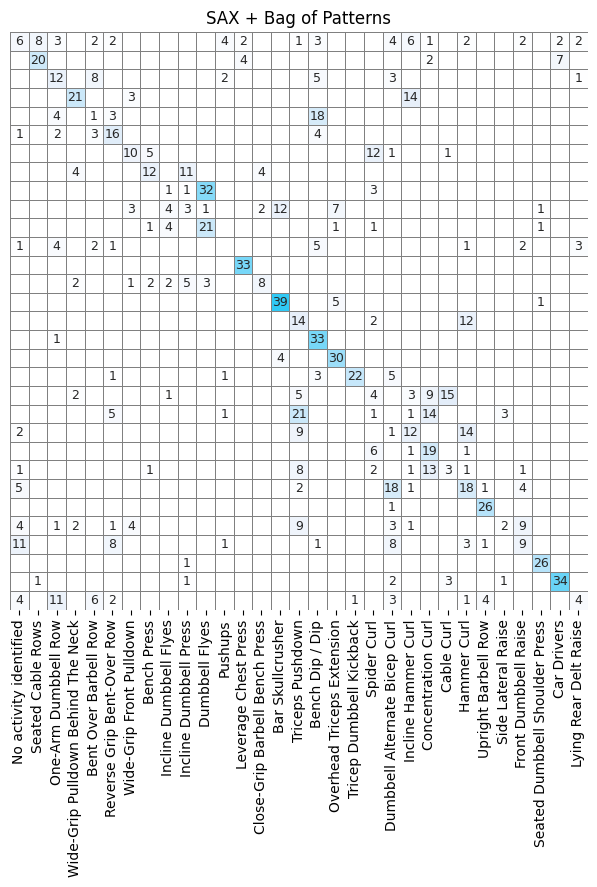

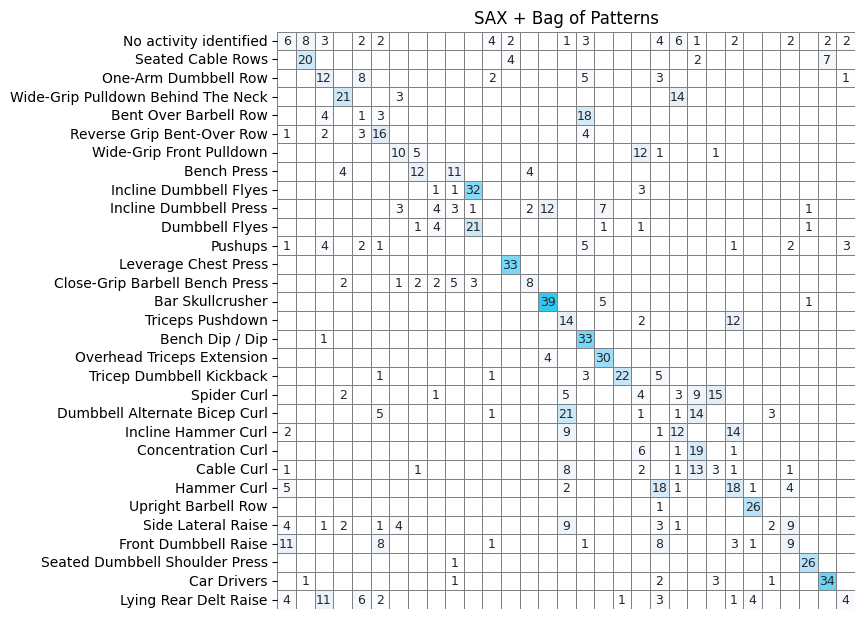

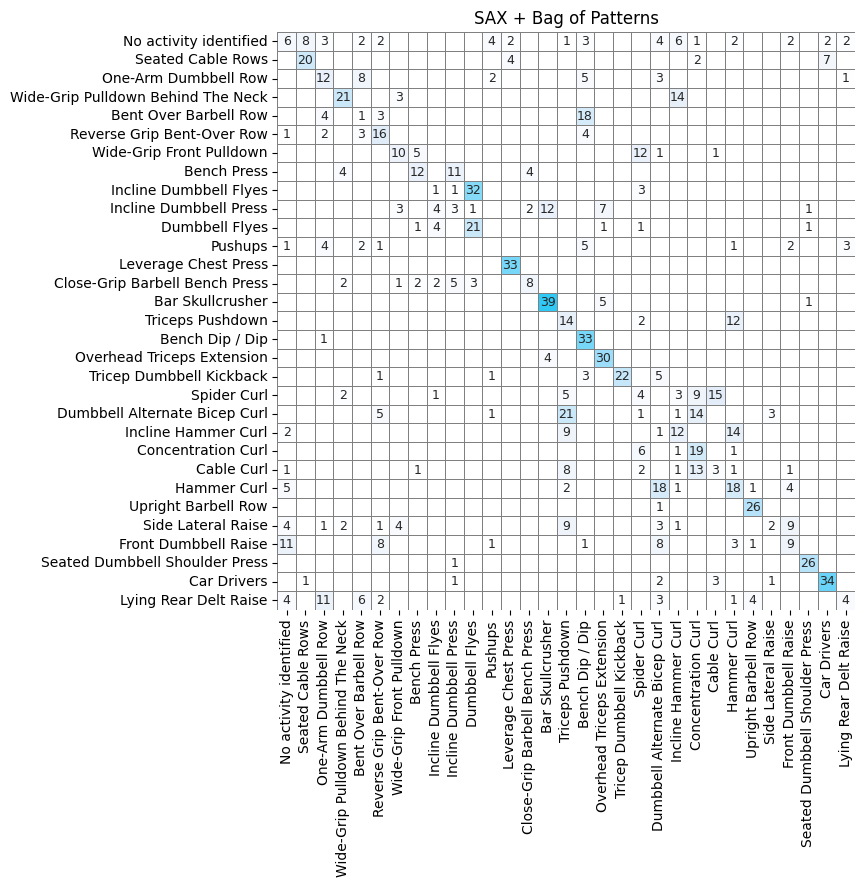

In [12]:
cm1 = confusion_matrix(y_test, predictions1_test, labels = classes)

# Save 4 copies of the confusion matrix, with different permutations of x_ticks and y_ticks turned on
plot_confusion_matrix(cm1, x_ticks = False, y_ticks = False, save = True, title = "SAX + Bag of Patterns")
plot_confusion_matrix(cm1, x_ticks = True, y_ticks = False, save = True, title = "SAX + Bag of Patterns")
plot_confusion_matrix(cm1, x_ticks = False, y_ticks = True, save = True, title = "SAX + Bag of Patterns")
plot_confusion_matrix(cm1, x_ticks = True, y_ticks = True, save = True, title = "SAX + Bag of Patterns")

## Approach 2: SAX - VSM

Introduced in [3], Symbolic Aggregation approXimation in Vector Space Model (SAX-VSM) computes a Term Frequency - Inverse Document Frequency (TF-IDF) matrix. Total counts of each word are computed by class, then normalised by the number of
classes within which the word was featured, ensuring common words have less predictive power and rare words associated with a single class have higher predictive power. Inference is performed by computing the cosine similarity between a new time series’ TF-IDF vector and each class in the TF-IDF matrix.

As per Approach 1, we apply SAX - VSM to the concatenation of the 6 dimensions in the dataset, defining this to be a *word.*

In [13]:
# Transform the words into a document-term matrix
vectoriser2 = TfidfVectorizer(max_features = 15000, min_df = 4)
x_train_vec2 = vectoriser2.fit_transform([' '.join(word) for word in x_train_d])
x_val_vec2 = vectoriser2.transform([' '.join(word) for word in x_val_d])
x_test_vec2 = vectoriser2.transform([' '.join(word) for word in x_test_d])

In [14]:
x_train_vec2 = np.asarray(x_train_vec2.todense())
x_val_vec2 = np.asarray(x_val_vec2.todense())
x_test_vec2 = np.asarray(x_test_vec2.todense())

In [15]:
# Train a k-nearest neighbors classifier
knn2 = KNeighborsClassifier(n_neighbors=10, metric = "cosine")
knn2.fit(x_train_vec2, y_train)

predictions2_val = knn2.predict(x_val_vec2)
predictions2_test = knn2.predict(x_test_vec2)

In [16]:
# Compare predictions against the targets
print("Validation Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions2_val), sum(np.equal(predictions2_val, y_val))))
print("Test Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions2_test), sum(np.equal(predictions2_test, y_test))))

Validation Data - Total predictions made: 1392. Number of correct predictions: 637
Test Data - Total predictions made: 1051. Number of correct predictions: 482


### Visualise predictions for test set

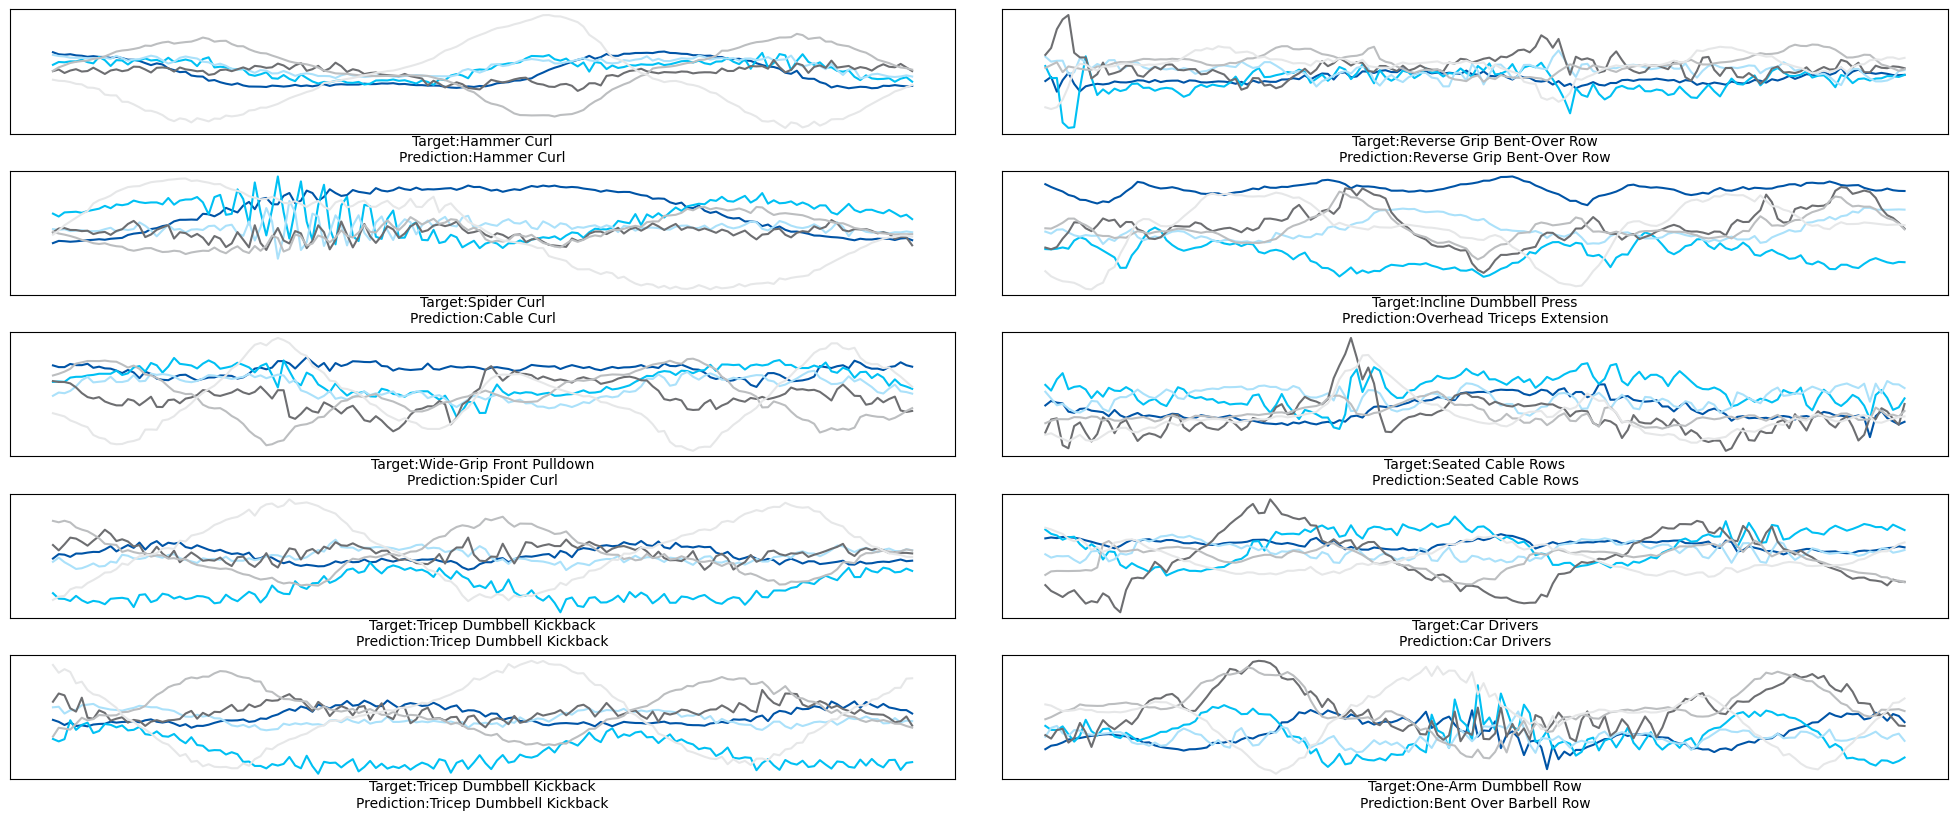

In [17]:
plot_samples(data = x_test, labels = y_test, predictions = predictions2_test)

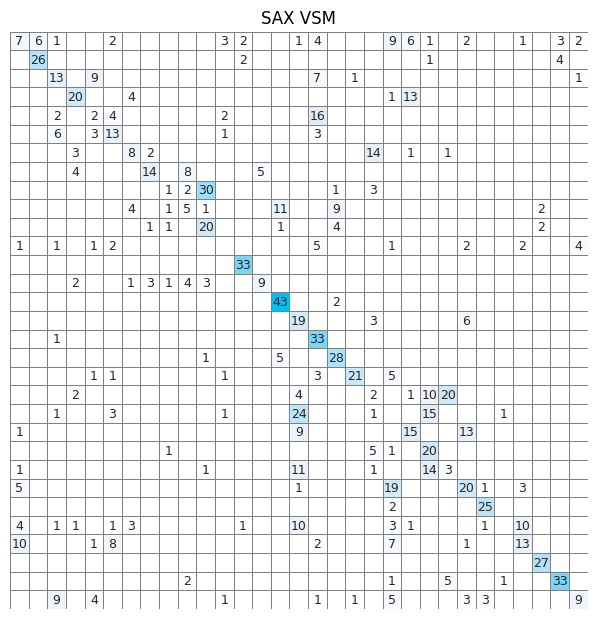

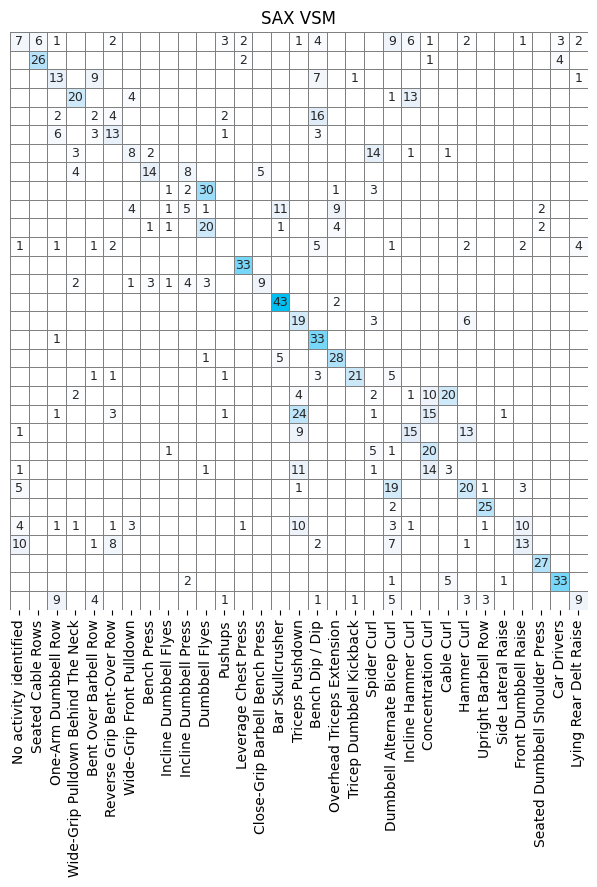

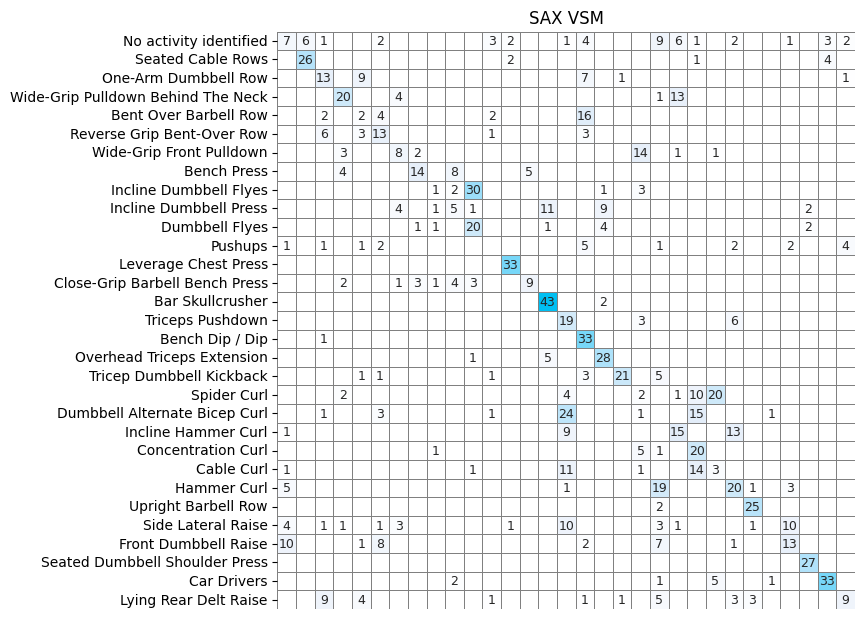

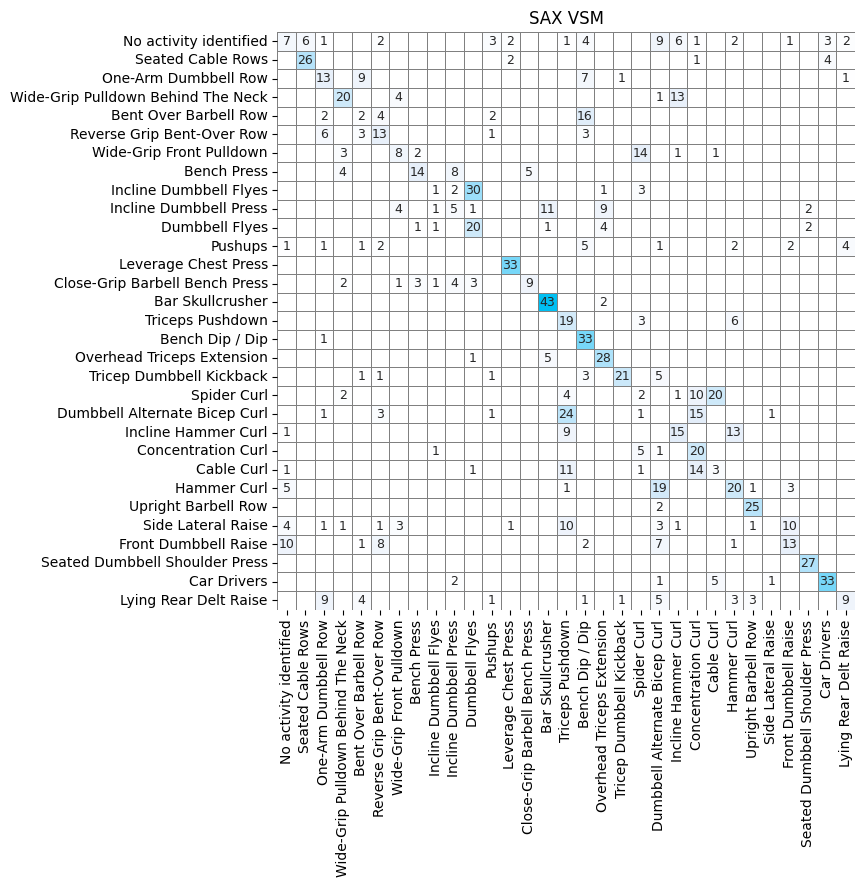

In [18]:
cm2 = confusion_matrix(y_test, predictions2_test, labels = classes)

# Save 4 copies of the confusion matrix, with different permutations of x_ticks and y_ticks turned on
plot_confusion_matrix(cm2, x_ticks = False, y_ticks = False, save = True, title = "SAX VSM")
plot_confusion_matrix(cm2, x_ticks = True, y_ticks = False, save = True, title = "SAX VSM")
plot_confusion_matrix(cm2, x_ticks = False, y_ticks = True, save = True, title = "SAX VSM")
plot_confusion_matrix(cm2, x_ticks = True, y_ticks = True, save = True, title = "SAX VSM")

## References

[1] Lin, Jessica, Eamonn J. Keogh, Li Wei and Stefano Lonardi. “Experiencing SAX: a novel symbolic representation of time series.” Data Mining and Knowledge Discovery 15 (2007): 107-144.

[2] Lin, Jessica, Rohan Khade and Yuan Li. “Rotation-invariant similarity in time series using bag-of-patterns representation.” Journal of Intelligent Information Systems 39 (2012): 287 - 315.

[3] Senin, Pavel and Sergey Malinchik. “SAX-VSM: Interpretable Time Series Classification Using SAX and Vector Space Model.” 2013 IEEE 13th International Conference on Data Mining (2013): 1175-1180.